# Gradient descent -- SUGRA potential with 4 parameters (x4,x5,x9,x10)

In this file, we

1) Read potentential from an external file

2) Choose the values for the parameters: 
    - Optimizer: e.g. Adam
    - n_points: Number of randomly initialised points
    - n_steps: Maximum number of steps in gradient descent algorithm
    - spread: size of the hypercube with initial data
    - alpha: initial learning rate
    - n_steps_opt: frequency with which the optimizer is rebooted
    - step_stop_opt: step from which the rebooting is cancelled

3) Perform gradient descent

4) Create /Output/ directory if unavailable and store:
    - Cloud of points and loss function into a .npy files
    - Ancillary file stating the choices above and showing the evolution of the learning process

5) Define visualisation functions


=========================

Changes since Oct 31st:

1) Directory of input file with potential changed
2) Number of variables 'dim' not defined in the notebook, but read from the input file

Changes since Nov 6th:

3) Gradient descent updated with optimiser rebooted every few steps

## Gradient Descent

In [1]:
import os
from importlib.machinery import SourceFileLoader

import numpy as np 
import tensorflow as tf

2024-12-19 19:20:57.498306: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-19 19:20:57.557613: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-19 19:20:57.574209: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-19 19:20:57.655086: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-19 19:20:58.992515: W tensorflow/compiler/tf2

In [8]:
##############################
# Parameters
##############################

potential = "pot_4_param_4_5_9_10"                          # .py file with potential function V(x) and the number of variables 'dim'

time = np.datetime_as_string(np.datetime64('now'))
time = time.replace('-','_').replace('T','_at_').replace(':','_')

n_points = 10000                                       # Number of randomly initialised points
n_steps = 40000                                          # Maximum number of steps in gradient descent algorithm
spread = 2.2                                            # Initial values for the cloud of points in the hypercube [-spread/2, spread/2]^dim


alpha=10**(-3)              # Initial learning rate
n_steps_opt = 200           # Number of steps before rebooting optimizer
step_stop_opt = 1        


optimizer = tf.keras.optimizers.Adam(learning_rate=alpha)

optimizer_info = optimizer.get_config()

In [19]:
print(time)

2024_12_19_at_19_03_21


In [10]:
# Saving directory
out_dir = os.getcwd()+'/Output/'

try:
    os.mkdir(out_dir)
    print(f"Directory '{out_dir}' created successfully.")
except FileExistsError:
    print(f"Directory '{out_dir}' already exists.")
except PermissionError:
    print(f"Permission denied: Unable to create '{out_dir}'.")
except Exception as e:
    print(f"An error occurred: {e}")


# Output File names
attempt = f"_{potential}_{n_points}_{time}"

info_file = out_dir + 'Comments' + attempt + '.txt'
data_file = out_dir + 'Points' + attempt + '.npy'
loss_file = out_dir + 'Loss' + attempt + '.npy'


f_info = open(info_file, 'w')


f_info.write(f'File created on {time}')
f_info.write(f'\n\nPotential : {potential}')
f_info.write(f'\nNumber of points: {n_points}')
f_info.write(f'\nNumber of steps: {n_steps}\n')
f_info.write(f'\nn_steps_opt: {n_steps_opt}\n')
f_info.write(f'\nstep_stop_opt: {step_stop_opt}\n')
f_info.write('\nOptimizer:\n')


for key, value in optimizer_info.items(): 
    f_info.write('  - %s : %s\n' % (key, value))

f_info.write('\nEvolution:')
f_info.flush()

Directory '/home/camille/Documents/Science/MLFlatDirections/Output/' already exists.


In [11]:
# Loading the potential
module = SourceFileLoader(potential,os.getcwd()+'/Potential_generator/'+potential+'.py').load_module()
V = module.V
dim = module.dim

print(dim)
help(V)

4
Help on function V in module pot_4_param_4_5_9_10:

V(x)
    0.125 * (tf.exp(-4 * (3 ** -0.5) * x9)) * (20 * (tf.exp(4 * (3 ** -0.5) * x9)) + 8 * (tf.exp(2 * (3 ** -0.5) * x9)) * (-1 + 4 * (x4 ** 2)) + 4 * ((1 + 4 * (x4 ** 2)) ** 2) -4 * (tf.exp(5 * (3 ** -0.5) * x9)) * (4 + x10 ** 2 -8 * (x5 ** 2)) -4 * (tf.exp((np.sqrt(3)) * x9)) * (4 + (x10 ** 2) * (1 + 4 * (x4 ** 2)) + 8 * (x5 ** 2) + (x4 ** 2) * (16 -32 * (x5 ** 2))) + (tf.exp(2 * (np.sqrt(3)) * x9)) * (x10 ** 4 + 64 * (x5 ** 4) + 8 * (x10 ** 2) * (1 + 2 * (x5 ** 2))))



In [12]:
# compute (||∇V||^2)
def grad_norm_squared(V, x):
    
    # Record operations for automatic differentiation:
    with tf.GradientTape() as tape:
        tape.watch(x)
        loss = V(x)                                     # compute V at each point
    gradients = tape.gradient(loss, x)                  # compute ∇V at each point
    norm_squared = tf.reduce_sum(gradients**2, axis=1)  # ||∇V||^2 at each point
    return norm_squared

In [13]:
# Randomly initialize the points
x = tf.Variable(spread*np.random.rand(n_points, dim)-(spread/2), dtype=tf.float32)


loss_history = []


# Learning loop 
for step in range(n_steps):  
    with tf.GradientTape() as tape:
        loss = tf.reduce_sum(grad_norm_squared(V, x))  # minimize ||∇V||^2 for all points
        loss_history.append(loss)
    
    # Compute ||∇V||^2 with respect to x
    gradients = tape.gradient(loss, [x])
        
    # Apply gradient descent for all points
    optimizer.apply_gradients(zip(gradients, [x]))
    
    # Update the information in info file
    if step % 500 == 0:
        f_info.write(f"\n  Step {step}: ||∇V||^2 = {loss.numpy()}")
        f_info.flush()
        
    if np.log(loss.numpy())/np.log(10)<-6: 
        f_info.write("\n\nConverged enough") 
        f_info.write(f"\n  Step {step}: ||∇V||^2 = {loss.numpy()}")
        break

f_info.close()

# Saving loss and final cloud of points
np.save(data_file,x)
np.save(loss_file,loss_history)

In [ ]:
# # Randomly initialize the points
# x = tf.Variable(np.random.rand(n_points, 3)+1, dtype=tf.float32)


# loss_history = []

# update_opt = False


# # Learning loop 
# for step in range(n_steps):  
#     with tf.GradientTape() as tape:
#         loss = tf.reduce_sum(grad_norm_squared(V, x))  # minimize ||∇V||^2 for all points
#         loss_history.append(loss)
    
#     # Compute ||∇V||^2 with respect to x
#     gradients = tape.gradient(loss, [x])
        
#     # Apply gradient descent for all points
#     optimizer.apply_gradients(zip(gradients, [x]))
    
#     # Updates of optimizer
#     if update_opt and step % n_steps_opt ==0 :
#         print("Reinitializing the optimizer")
#         optimizer = tf.optimizers.Adam(learning_rate=alpha)

#     if step == step_stop_opt:
#         update_opt = False
    
#     if (step - step_stop_opt)%(3*n_steps_opt) == 0:
#         alpha = alpha/10
#         optimizer = tf.optimizers.Adam(learning_rate=alpha)


#     # Update the information in info file
#     if step % 500 == 0:
#         f_info.write(f"\n  Step {step}: ||∇V||^2 = {loss.numpy()}")
#         f_info.flush()
        
#     if np.log(loss.numpy())/np.log(10)<-8: 
#         f_info.write("\n\nConverged enough") 
#         f_info.write(f"\n  Step {step}: ||∇V||^2 = {loss.numpy()}")
#         break

# f_info.close()

# # Saving loss and final cloud of points
# np.save(data_file,x)
# np.save(loss_file,loss_history)

## Results

In [1]:
import os
from importlib.machinery import SourceFileLoader

import numpy as np 
import matplotlib.pyplot as plt

from matplotlib.colors import LogNorm

import tensorflow as tf

2024-12-23 20:46:33.373542: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-23 20:46:33.440720: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-23 20:46:33.458295: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-23 20:46:33.539874: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-23 20:46:35.078984: W tensorflow/compiler/tf2

### Functions

In [2]:
# compute (||∇V||^2)
def grad_norm_squared(V, x):
    
    # Record operations for automatic differentiation:
    with tf.GradientTape() as tape:
        tape.watch(x)
        loss = V(x)                                     # compute V at each point
    gradients = tape.gradient(loss, x)                  # compute ∇V at each point
    norm_squared = tf.reduce_sum(gradients**2, axis=1)  # ||∇V||^2 at each point
    return norm_squared

In [3]:
def triangular_plot(chains):
    data=chains
    nsteps,ndim=chains.shape
    fig = plt.figure(figsize=(20,20))
    for i in range(ndim):
        ax = fig.add_subplot(ndim,ndim,i*ndim+i+1)
        
        ax.hist(data[:,i], 100, color="k", histtype="step")
        ax.set_title(f"x{i+1} counts")

    for i in range(ndim):
        for j in range(i):
            ax = fig.add_subplot(ndim,ndim,i*ndim+j+1)
            counts,xbins,ybins,image = ax.hist2d(data[:,j],data[:,i],bins=100, norm=LogNorm(), cmap = plt.cm.rainbow)
            plt.colorbar(image)
            ax.contour(counts.transpose(),extent=[xbins[0],xbins[-1],ybins[0],ybins[-1]], linewidths=0.5, cmap = plt.cm.rainbow, levels = [1,100,1000,10000])
            ax.set_xlabel(f'x{j+1}')
            ax.set_ylabel(f'x{i+1}')
    plt.show()

def triangular_plot_axes_lim(chains,mask):
    data=chains
    nsteps,ndim=chains.shape
    fig = plt.figure(figsize=(20,20))
    for i in range(ndim):
        ax = fig.add_subplot(ndim,ndim,i*ndim+i+1)
        
        ax.hist(data[:,i], 100, color="k", histtype="step")
        ax.set_title(f"x{i+1} counts")

    for i in range(ndim):
        for j in range(i):
            ax = fig.add_subplot(ndim,ndim,i*ndim+j+1)
            counts,xbins,ybins,image = ax.hist2d(data[mask,j],data[mask,i],bins=100, norm=LogNorm(), cmap = plt.cm.rainbow)
            plt.colorbar(image)
            ax.contour(counts.transpose(),extent=[xbins[0],xbins[-1],ybins[0],ybins[-1]], linewidths=0.5, cmap = plt.cm.rainbow, levels = [1,100,1000,10000])
            ax.set_xlabel(f'x{j+1}')
            ax.set_ylabel(f'x{i+1}')
            ax.set_xlim([np.min(data[:,j]), np.max(data[:,j])])
            ax.set_ylim([np.min(data[:,i]), np.max(data[:,i])])
    plt.show()
    
# def triangular_plot(chains,figname):
#     data=chains
#     nsteps,ndim=chains.shape
#     fig = plt.figure(figsize=(20,20))
#     for i in range(ndim):
#         ax = fig.add_subplot(ndim,ndim,i*ndim+i+1)
        
#         ax.hist(data[:,i], 100, color="k", histtype="step")
#         ax.set_title(f"x{i+1} counts")

#     for i in range(ndim):
#         for j in range(i):
#             ax = fig.add_subplot(ndim,ndim,i*ndim+j+1)
#             counts,xbins,ybins,image = ax.hist2d(data[:,j],data[:,i],bins=100, norm=LogNorm(), cmap = plt.cm.rainbow)
#             plt.colorbar(image)
#             ax.contour(counts.transpose(),extent=[xbins[0],xbins[-1],ybins[0],ybins[-1]], linewidths=0.5, cmap = plt.cm.rainbow, levels = [1,100,1000,10000])
#             ax.set_xlabel(f'x{j+1}')
#             ax.set_ylabel(f'x{i+1}')
#     plt.savefig(figname)
#     plt.show()


def triangular_plot_slopes(chains):
    data=chains.numpy()
    nsteps,ndim=chains.shape
    fig = plt.figure(figsize=(15,15))
    for i in range(ndim):
        for j in range(i):
            ax=fig.add_subplot(ndim,ndim,ndim*i+j+1)
            those_slope0=np.extract(np.abs(data[:,0])>0.2,data[:,i]/data[:,j])
            those_slope=np.extract(np.abs(those_slope0)<10,those_slope0)
            ax.hist(those_slope,bins=100)
            ax.set_title(f"x{j}/x{i}")
    plt.show()

### Analysis

In [21]:
# Loading the potential
potential = "pot_4_param_4_5_9_10"                         # .py file with potential function V(x)
module = SourceFileLoader(potential,os.getcwd()+'/Potential_generator/'+potential+'.py').load_module()
V = module.V
dim = module.dim

out_dir = os.getcwd()+'/Output/'
time = '2024_12_19_at_19_03_21'
n_points = 10000

attempt = f"_{potential}_{n_points}_{time}"

data_file = out_dir + 'Points' + attempt + '.npy'
loss_file = out_dir + 'Loss' + attempt + '.npy'

In [22]:

x = tf.Variable(np.load(data_file), dtype=tf.float32)
loss_history = np.load(loss_file)

In [23]:
for i in range(15):
    print(f"Number of points with ||∇V||^2 > {10**(-i)} : {sum(grad_norm_squared(V,x).numpy()>10**(-i))}")

Number of points with ||∇V||^2 > 1 : 0
Number of points with ||∇V||^2 > 0.1 : 0
Number of points with ||∇V||^2 > 0.01 : 0
Number of points with ||∇V||^2 > 0.001 : 0
Number of points with ||∇V||^2 > 0.0001 : 2
Number of points with ||∇V||^2 > 1e-05 : 174
Number of points with ||∇V||^2 > 1e-06 : 637
Number of points with ||∇V||^2 > 1e-07 : 1301
Number of points with ||∇V||^2 > 1e-08 : 2254
Number of points with ||∇V||^2 > 1e-09 : 3254
Number of points with ||∇V||^2 > 1e-10 : 3917
Number of points with ||∇V||^2 > 1e-11 : 4326
Number of points with ||∇V||^2 > 1e-12 : 5092
Number of points with ||∇V||^2 > 1e-13 : 7692
Number of points with ||∇V||^2 > 1e-14 : 9594


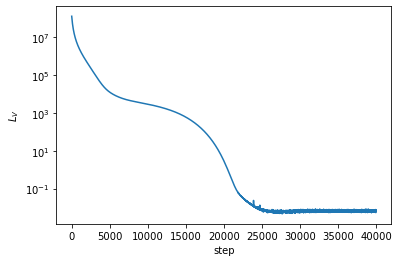

In [24]:
plt.figure(1)
plt.plot(loss_history)
plt.yscale('log')
plt.xlabel('step')
plt.ylabel('$L_{V}$')
plt.show()

<Figure size 432x288 with 0 Axes>

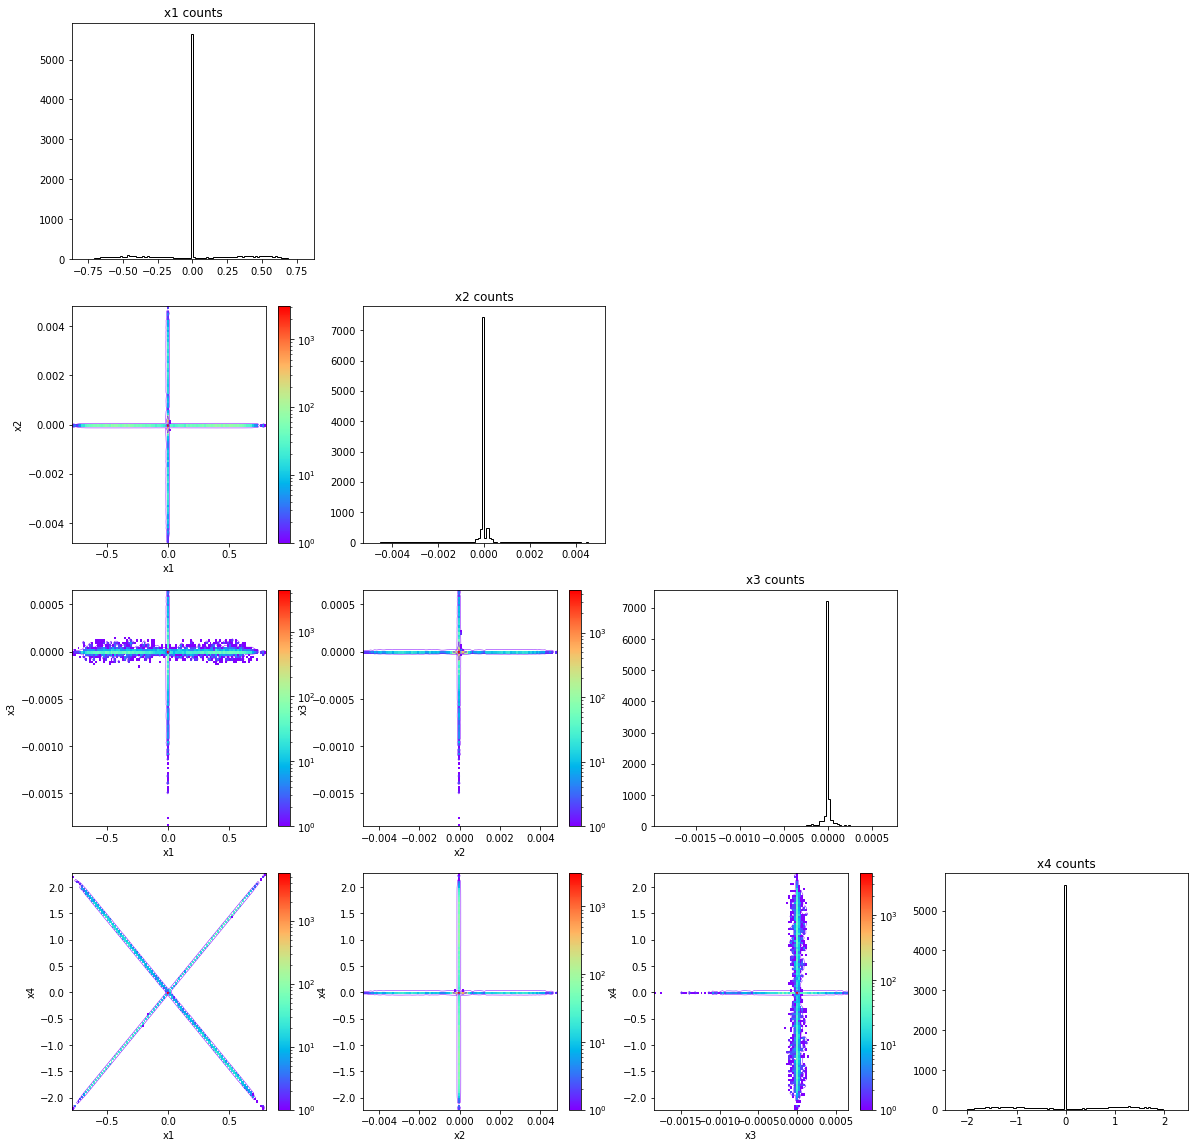

In [25]:
plt.figure(1)
triangular_plot(x.numpy())

Sum of the points are runaway (V\neq-2), we exclude them.

In [26]:
mask=(np.abs(V(x)+2)<1e-3)[:,0]

np.sum(mask)

10000

No one to be excluded.

# Autoencoder

In [4]:
import os
from importlib.machinery import SourceFileLoader


import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import tensorflow as tf

from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models
from tensorflow.keras.models import Model

In [5]:
# Loading the potential
potential = "pot_4_param_4_5_9_10"                         # .py file with potential function V(x)
module = SourceFileLoader(potential,os.getcwd()+'/Potential_generator/'+potential+'.py').load_module()
V = module.V
dim = module.dim

out_dir = os.getcwd()+'/Output/'
time = '2024_12_19_at_19_03_21'
n_points = 10000

attempt = f"_{potential}_{n_points}_{time}"

data_file = out_dir + 'Points' + attempt + '.npy'
loss_file = out_dir + 'Loss' + attempt + '.npy'
AE_loss_file = out_dir + 'AE_all_loss' + attempt + '.npy'
AE_val_loss_file = out_dir + 'AE_all_val_loss' + attempt + '.npy'

In [6]:
x = np.load(data_file)
loss_history = np.load(loss_file)

In [7]:
x_train, x_test = train_test_split(x, test_size=0.15, random_state=42)

In [8]:
print(f'shape of total set of points: {x.shape}')
print(f'shape of training set of points: {x_train.shape}')
print(f'shape of validation set of points: {x_test.shape}')

shape of total set of points: (10000, 4)
shape of training set of points: (8500, 4)
shape of validation set of points: (1500, 4)


## Determining the dimension of the conformal manifold

### Latent dimension = 1

In [6]:
input_dim = dim  
latent_dim = 1  

# Encoder
inputs = layers.Input(shape=(input_dim,))
encoded = layers.Dense(32, activation='sigmoid')(inputs)
encoded = layers.Dense(16, activation='sigmoid')(encoded)
encoded = layers.Dense(8, activation='sigmoid')(encoded)
encoded = layers.Dense(latent_dim)(encoded)  

# Decoder
decoded = layers.Dense(8, activation='sigmoid')(encoded)
decoded = layers.Dense(16, activation='sigmoid')(decoded)
decoded = layers.Dense(32, activation='sigmoid')(decoded)
decoded = layers.Dense(input_dim)(decoded)  

# Autoencoder 
autoencoder = models.Model(inputs, decoded)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
autoencoder.compile(optimizer=optimizer, loss='mse')

I0000 00:00:1734676929.887994    6677 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1734676930.001092    6677 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1734676930.001664    6677 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1734676930.003796    6677 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

In [7]:
autoencoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 4)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │             9 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 8)              │            16 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 16)             │           144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,669 (6.52 KB)

 Trainable params: 1,669 (6.52 KB)

 Non-trainable params: 0 (0.00 B)

In [8]:
epochs = 10000
history_AE_1 = autoencoder.fit(x_train, x_train, epochs=epochs, batch_size=100, shuffle=True,validation_data=(x_test, x_test))

Epoch 1/10000


I0000 00:00:1734676933.385160    6797 service.cc:146] XLA service 0x7a2400005540 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734676933.385203    6797 service.cc:154]   StreamExecutor device (0): Quadro T2000 with Max-Q Design, Compute Capability 7.5
2024-12-20 07:42:13.445812: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-12-20 07:42:13.719402: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


82/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8438

I0000 00:00:1734676935.498555    6797 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


85/85 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.8411 - val_loss: 0.6651
Epoch 2/10000
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6217 - val_loss: 0.4966
Epoch 3/10000
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4742 - val_loss: 0.3777
Epoch 4/10000
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3629 - val_loss: 0.2960
Epoch 5/10000
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2811 - val_loss: 0.2422
Epoch 6/10000
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2289 - val_loss: 0.2088
Epoch 7/10000
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2063 - val_loss: 0.1893
Epoch 8/10000
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1889 - val_loss: 0.1788
Epoch 9/10000
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1794 - val_loss: 0.1736
Epoch 10/10000
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1776 - val_loss: 0.1712
Epoch 11/10000
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1713 - val_loss: 0.1702
Epoch 12/10000
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step -

In [9]:
autoencoder_1 = autoencoder
encoder_1 = models.Model(inputs,encoded)
decoder_1 = models.Model(encoded,decoded)

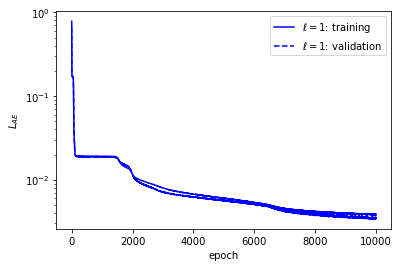

In [10]:
plt.plot(history_AE_1.history['loss'], label='$\ell=1$: training',color='blue')
plt.plot(history_AE_1.history['val_loss'], label='$\ell=1$: validation',color='blue',linestyle='--')
plt.yscale('log')
plt.xlabel('epoch')
plt.ylabel('$L_{AE}$')
plt.legend()

In [ ]:
# AE_file = out_dir + 'AE_l1' + attempt + '.keras'
# autoencoder_1.save(AE_file)

In [ ]:
# loss_history_all = np.array([history_AE_1.history['loss']]) #,history_AE_2.history['loss'],history_AE_3.history['loss']])
# val_loss_history_all = np.array([history_AE_1.history['val_loss']]) #,history_AE_2.history['val_loss'],history_AE_3.history['val_loss']])

# np.save(AE_loss_file,loss_history_all)
# np.save(AE_val_loss_file,val_loss_history_all)

### Latent dimension = 2

In [9]:
input_dim = dim  
latent_dim = 2

# Encoder
inputs = layers.Input(shape=(input_dim,))
encoded = layers.Dense(32, activation='sigmoid')(inputs)
encoded = layers.Dense(16, activation='sigmoid')(encoded)
encoded = layers.Dense(8, activation='sigmoid')(encoded)
encoded = layers.Dense(latent_dim)(encoded)  

# Decoder
decoded = layers.Dense(8, activation='sigmoid')(encoded)
decoded = layers.Dense(16, activation='sigmoid')(decoded)
decoded = layers.Dense(32, activation='sigmoid')(decoded)
decoded = layers.Dense(input_dim)(decoded)  

# Autoencoder 
autoencoder = models.Model(inputs, decoded)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
autoencoder.compile(optimizer=optimizer, loss='mse')

I0000 00:00:1734680707.179708    7092 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1734680707.278666    7092 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1734680707.278898    7092 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1734680707.280624    7092 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

In [10]:
autoencoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 4)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │            18 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 8)              │            24 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 16)             │           144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,686 (6.59 KB)

 Trainable params: 1,686 (6.59 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:
epochs = 10000
history_AE_2 = autoencoder.fit(x_train, x_train, epochs=epochs, batch_size=100, shuffle=True,validation_data=(x_test, x_test))

Epoch 1/10000


I0000 00:00:1734680711.375923    7299 service.cc:146] XLA service 0x7fa0a400fa20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734680711.375950    7299 service.cc:154]   StreamExecutor device (0): Quadro T2000 with Max-Q Design, Compute Capability 7.5
2024-12-20 08:45:11.428792: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-12-20 08:45:11.670173: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


61/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.1689

I0000 00:00:1734680714.202224    7299 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


85/85 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 2.1245 - val_loss: 1.7112
Epoch 2/10000
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.6077 - val_loss: 1.3022
Epoch 3/10000
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.2211 - val_loss: 0.9934
Epoch 4/10000
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9280 - val_loss: 0.7610
Epoch 5/10000
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7223 - val_loss: 0.5877
Epoch 6/10000
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5541 - val_loss: 0.4604
Epoch 7/10000
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4321 - val_loss: 0.3676
Epoch 8/10000
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3493 - val_loss: 0.3013
Epoch 9/10000
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2934 - val_loss: 0.2548
Epoch 10/10000
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2520 - val_loss: 0.2232
Epoch 11/10000
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2166 - val_loss: 0.2023
Epoch 12/10000
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step -

In [12]:
autoencoder_2 = autoencoder
encoder_2 = models.Model(inputs,encoded)
decoder_2 = models.Model(encoded,decoded)

In [ ]:
# loss1=np.load(AE_loss_file)[0]
# valloss1=np.load(AE_val_loss_file)[0]

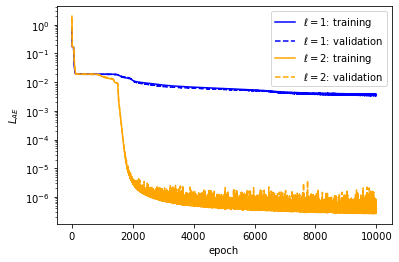

In [ ]:
# plt.plot(loss1, label='$\ell=1$: training',color='blue')
# plt.plot(valloss1, label='$\ell=1$: validation',color='blue',linestyle='--')
plt.plot(history_AE_1.history['loss'], label='$\ell=1$: training',color='blue')
plt.plot(history_AE_1.history['val_loss'], label='$\ell=1$: validation',color='blue',linestyle='--')
plt.plot(history_AE_2.history['loss'], label='$\ell=2$: training',color='orange')
plt.plot(history_AE_2.history['val_loss'], label='$\ell=2$: validation',color='orange',linestyle='--')
plt.yscale('log')
plt.xlabel('epoch')
plt.ylabel('$L_{AE}$')
plt.legend()

In [36]:
AE_file = out_dir + 'AE_l2' + attempt + '.keras'
autoencoder_2.save(AE_file)

In [ ]:
# loss_history_all = np.array([loss1,history_AE_2.history['loss']])#,history_AE_3.history['loss']])
# val_loss_history_all = np.array([valloss1,history_AE_2.history['val_loss']])#,history_AE_3.history['val_loss']])

loss_history_all = np.array([history_AE_1.history['loss'],history_AE_2.history['loss']])#,history_AE_3.history['loss']])
val_loss_history_all = np.array([history_AE_1.history['val_loss'],history_AE_2.history['val_loss']])#,history_AE_3.history['val_loss']])

np.save(AE_loss_file,loss_history_all)
np.save(AE_val_loss_file,val_loss_history_all)

### Latent dimension = 3

In [23]:
input_dim = dim  
latent_dim = 3

# Encoder
inputs = layers.Input(shape=(input_dim,))
encoded = layers.Dense(32, activation='sigmoid')(inputs)
encoded = layers.Dense(16, activation='sigmoid')(encoded)
encoded = layers.Dense(8, activation='sigmoid')(encoded)
encoded = layers.Dense(latent_dim)(encoded)  

# Decoder
decoded = layers.Dense(8, activation='sigmoid')(encoded)
decoded = layers.Dense(16, activation='sigmoid')(decoded)
decoded = layers.Dense(32, activation='sigmoid')(decoded)
decoded = layers.Dense(input_dim)(decoded)  

# Autoencoder 
autoencoder = models.Model(inputs, decoded)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
autoencoder.compile(optimizer=optimizer, loss='mse')

In [24]:
autoencoder.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 4)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 32)             │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 3)              │            27 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 8)              │            32 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 16)             │           144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,703 (6.65 KB)

 Trainable params: 1,703 (6.65 KB)

 Non-trainable params: 0 (0.00 B)

In [25]:
epochs = 10000
history_AE_3 = autoencoder.fit(x_train, x_train, epochs=epochs, batch_size=100, shuffle=True,validation_data=(x_test, x_test))

Epoch 1/10000
85/85 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.5443 - val_loss: 0.3971
Epoch 2/10000
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3719 - val_loss: 0.2832
Epoch 3/10000
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2669 - val_loss: 0.2209
Epoch 4/10000
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2128 - val_loss: 0.1900
Epoch 5/10000
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1892 - val_loss: 0.1766
Epoch 6/10000
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1811 - val_loss: 0.1716
Epoch 7/10000
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1769 - val_loss: 0.1700
Epoch 8/10000
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1702 - val_loss: 0.1697
Epoch 9/10000
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1661 - val_loss: 0.1696
Epoch 10/10000
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1711 - val_loss: 0.1696
Epoch 11/10000
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1735 - val_loss: 0.1696
Epoch 12/10000
85/85 ━━━━━━━━━━━━━━━━━━━━

In [26]:
autoencoder_3 = autoencoder
encoder_3 = models.Model(inputs,encoded)
decoder_3 = models.Model(encoded,decoded)

In [ ]:
# AE_file = out_dir + 'AE_l3' + attempt + '.keras'
# autoencoder_3.save(AE_file)

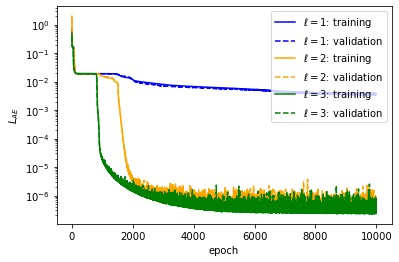

In [ ]:
# plt.plot(loss1, label='$\ell=1$: training',color='blue')
# plt.plot(valloss1, label='$\ell=1$: validation',color='blue',linestyle='--')
plt.plot(history_AE_1.history['loss'], label='$\ell=1$: training',color='blue')
plt.plot(history_AE_1.history['val_loss'], label='$\ell=1$: validation',color='blue',linestyle='--')
plt.plot(history_AE_2.history['loss'], label='$\ell=2$: training',color='orange')
plt.plot(history_AE_2.history['val_loss'], label='$\ell=2$: validation',color='orange',linestyle='--')
plt.plot(history_AE_3.history['loss'], label='$\ell=3$: training',color='green')
plt.plot(history_AE_3.history['val_loss'], label='$\ell=3$: validation',color='green',linestyle='--')

plt.yscale('log')
plt.xlabel('epoch')
plt.ylabel('$L_{AE}$')
plt.legend()

plt.show()

# plt.savefig('../LaTeX/Notes/Figures/lossAE_higgs.png')

In [ ]:
# loss_history_all = np.array([loss1,history_AE_2.history['loss'],history_AE_3.history['loss']])
# val_loss_history_all = np.array([valloss1,history_AE_2.history['val_loss'],history_AE_3.history['val_loss']])
loss_history_all = np.array([history_AE_1.history['loss'],history_AE_2.history['loss'],history_AE_3.history['loss']])
val_loss_history_all = np.array([history_AE_1.history['val_loss'],history_AE_2.history['val_loss'],history_AE_3.history['val_loss']])

np.save(AE_loss_file,loss_history_all)
np.save(AE_val_loss_file,val_loss_history_all)

### Latent dimension = 4

In [30]:
input_dim = dim  
latent_dim = 4

# Encoder
inputs = layers.Input(shape=(input_dim,))
encoded = layers.Dense(32, activation='sigmoid')(inputs)
encoded = layers.Dense(16, activation='sigmoid')(encoded)
encoded = layers.Dense(8, activation='sigmoid')(encoded)
encoded = layers.Dense(latent_dim)(encoded)  

# Decoder
decoded = layers.Dense(8, activation='sigmoid')(encoded)
decoded = layers.Dense(16, activation='sigmoid')(decoded)
decoded = layers.Dense(32, activation='sigmoid')(decoded)
decoded = layers.Dense(input_dim)(decoded)  

# Autoencoder 
autoencoder = models.Model(inputs, decoded)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
autoencoder.compile(optimizer=optimizer, loss='mse')

In [31]:
autoencoder.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 4)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 32)             │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 4)              │            36 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 8)              │            40 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 16)             │           144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,720 (6.72 KB)

 Trainable params: 1,720 (6.72 KB)

 Non-trainable params: 0 (0.00 B)

In [32]:
epochs = 10000
history_AE_4 = autoencoder.fit(x_train, x_train, epochs=epochs, batch_size=100, shuffle=True,validation_data=(x_test, x_test))

Epoch 1/10000
85/85 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.6907 - val_loss: 0.5191
Epoch 2/10000
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4806 - val_loss: 0.3668
Epoch 3/10000
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3430 - val_loss: 0.2727
Epoch 4/10000
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2607 - val_loss: 0.2191
Epoch 5/10000
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2090 - val_loss: 0.1912
Epoch 6/10000
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1884 - val_loss: 0.1780
Epoch 7/10000
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1814 - val_loss: 0.1726
Epoch 8/10000
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1768 - val_loss: 0.1706
Epoch 9/10000
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1701 - val_loss: 0.1699
Epoch 10/10000
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1762 - val_loss: 0.1697
Epoch 11/10000
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1708 - val_loss: 0.1697
Epoch 12/10000
85/85 ━━━━━━━━━━━━━━━━━━━━

In [33]:
autoencoder_4 = autoencoder
encoder_4 = models.Model(inputs,encoded)
decoder_4 = models.Model(encoded,decoded)

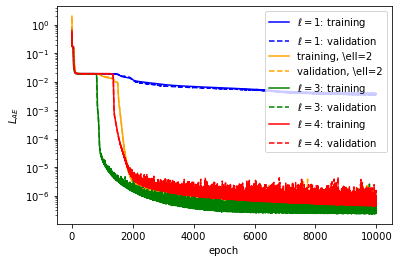

In [ ]:
# plt.plot(loss1, label='$\ell=1$: training',color='blue')
# plt.plot(valloss1, label='$\ell=1$: validation',color='blue',linestyle='--')
plt.plot(history_AE_1.history['loss'], label='$\ell=1$: training',color='blue')
plt.plot(history_AE_1.history['val_loss'], label='$\ell=1$: validation',color='blue',linestyle='--')
plt.plot(history_AE_2.history['loss'], label='training, \ell=2',color='orange')
plt.plot(history_AE_2.history['val_loss'], label='validation, \ell=2',color='orange',linestyle='--')
plt.plot(history_AE_3.history['loss'], label='$\ell=3$: training',color='green')
plt.plot(history_AE_3.history['val_loss'], label='$\ell=3$: validation',color='green',linestyle='--')
plt.plot(history_AE_4.history['loss'], label='$\ell=4$: training',color='red')
plt.plot(history_AE_4.history['val_loss'], label='$\ell=4$: validation',color='red',linestyle='--')

plt.yscale('log')
plt.xlabel('epoch')
plt.ylabel('$L_{AE}$')
plt.legend()

plt.show()

# plt.savefig('../LaTeX/Notes/Figures/lossAE_higgs.png')

In [ ]:
# loss_history_all = np.array([loss1,history_AE_2.history['loss'],history_AE_3.history['loss'],history_AE_4.history['loss']])
# val_loss_history_all = np.array([valloss1,history_AE_2.history['val_loss'],history_AE_3.history['val_loss'],history_AE_4.history['val_loss']])
loss_history_all = np.array([history_AE_1.history['loss'],history_AE_2.history['loss'],history_AE_3.history['loss'],history_AE_4.history['loss']])
val_loss_history_all = np.array([history_AE_1.history['val_loss'],history_AE_2.history['val_loss'],history_AE_3.history['val_loss'],history_AE_4.history['val_loss']])

np.save(AE_loss_file,loss_history_all)
np.save(AE_val_loss_file,val_loss_history_all)

## Results and analysis of l = 2

### Loss functions

In [9]:
loss_history_all = np.load(AE_loss_file)
val_loss_history_all = np.load(AE_val_loss_file)

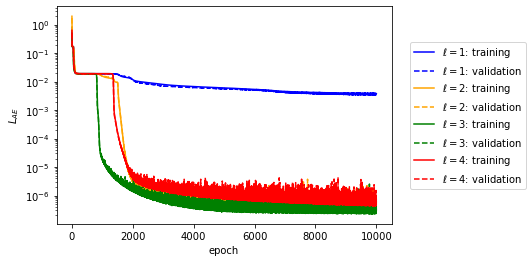

In [10]:
plt.plot(loss_history_all[0], label='$\ell=1$: training',color='blue')
plt.plot(val_loss_history_all[0], label='$\ell=1$: validation',color='blue',linestyle='--')
plt.plot(loss_history_all[1], label='$\ell=2$: training',color='orange')
plt.plot(val_loss_history_all[1], label='$\ell=2$: validation',color='orange',linestyle='--')
plt.plot(loss_history_all[2], label='$\ell=3$: training',color='green')
plt.plot(val_loss_history_all[2], label='$\ell=3$: validation',color='green',linestyle='--')
plt.plot(loss_history_all[3], label='$\ell=4$: training',color='red')
plt.plot(val_loss_history_all[3], label='$\ell=4$: validation',color='red',linestyle='--')

plt.yscale('log')
plt.xlabel('epoch')
plt.ylabel('$L_{AE}$')
plt.legend(bbox_to_anchor=(1.04, 0.5), loc="center left")

plt.show()

### Analysis of the l = 2 autoencoder

In [11]:
AE_file = out_dir + 'AE_l2' + attempt + '.keras'

autoencoder_2 = models.load_model(AE_file)
autoencoder_2.summary()

I0000 00:00:1734983223.316855    8941 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1734983223.406223    8941 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1734983223.406423    8941 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1734983223.408170    8941 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 4)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │            18 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 8)              │            24 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 16)             │           144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,060 (19.77 KB)

 Trainable params: 1,686 (6.59 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 3,374 (13.18 KB)

In [12]:
# Encoder
inputs = layers.Input(shape=(dim,))
encoded = autoencoder_2.layers[1](inputs)
encoded = autoencoder_2.layers[2](encoded)
encoded = autoencoder_2.layers[3](encoded)
encoded = autoencoder_2.layers[4](encoded)

encoder_2 = Model(inputs=inputs, outputs=encoded)

encoder_2.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 4)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │            18 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 842 (3.29 KB)

 Trainable params: 842 (3.29 KB)

 Non-trainable params: 0 (0.00 B)

In [13]:
# Decoder
decoded = autoencoder_2.layers[5](encoded)
decoded = autoencoder_2.layers[6](decoded)
decoded = autoencoder_2.layers[7](decoded)
decoded = autoencoder_2.layers[8](decoded)

decoder_2 = Model(inputs=encoded, outputs=decoded)

decoder_2.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ keras_tensor_20CLONE            │ (None, 2)              │             0 │
│ (InputLayer)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 8)              │            24 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 16)             │           144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 844 (3.30 KB)

 Trainable params: 844 (3.30 KB)

 Non-trainable params: 0 (0.00 B)

In [14]:
# test autoencoder
encoded_points = encoder_2.predict(x)

I0000 00:00:1734983224.713606    9108 service.cc:146] XLA service 0x78fe8c004cd0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734983224.713632    9108 service.cc:154]   StreamExecutor device (0): Quadro T2000 with Max-Q Design, Compute Capability 7.5
2024-12-23 20:47:04.724634: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-12-23 20:47:04.769462: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


102/313 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

I0000 00:00:1734983225.104826    9108 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


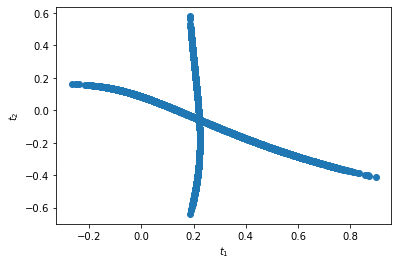

In [15]:
plt.scatter(encoded_points[:,0],encoded_points[:,1])
plt.xlabel('$t_1$')
plt.ylabel('$t_2$')
plt.show()

We see two intersecting lines.

# Tests clustering

In [ ]:
# agglomerative clustering
from sklearn.cluster import AgglomerativeClustering

model = AgglomerativeClustering(n_clusters=2)
# fit model and predict clusters
yhat = model.fit_predict(encoded_points)

mask_cluster1 = yhat==0
mask_cluster2 = yhat==1

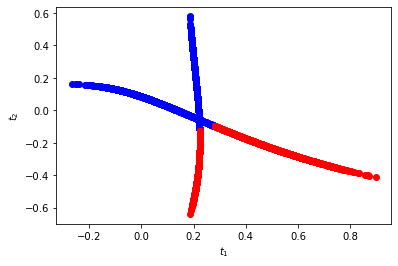

In [46]:
plt.scatter(encoded_points[mask_cluster1,0],encoded_points[mask_cluster1,1],color='blue')
plt.scatter(encoded_points[mask_cluster2,0],encoded_points[mask_cluster2,1],color='red')
plt.xlabel('$t_1$')
plt.ylabel('$t_2$')
plt.show()

In [87]:
# BIRCH clustering
from sklearn.cluster import Birch

model = Birch(threshold=0.01, n_clusters=2)
# fit model and predict clusters
yhat = model.fit_predict(encoded_points)

mask_cluster1 = yhat==0
mask_cluster2 = yhat==1
# mask_cluster3 = yhat==2
# mask_cluster4 = yhat==3

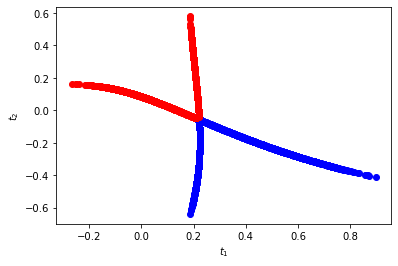

In [88]:
plt.scatter(encoded_points[mask_cluster1,0],encoded_points[mask_cluster1,1],color='blue')
plt.scatter(encoded_points[mask_cluster2,0],encoded_points[mask_cluster2,1],color='red')
# plt.scatter(encoded_points[mask_cluster3,0],encoded_points[mask_cluster3,1],color='green')
# plt.scatter(encoded_points[mask_cluster4,0],encoded_points[mask_cluster4,1],color='yellow')
plt.xlabel('$t_1$')
plt.ylabel('$t_2$')
plt.show()

In [ ]:
# DBSCAN clustering
from sklearn.cluster import DBSCAN

model = DBSCAN(eps=0.30, min_samples=9)
# fit model and predict clusters
yhat = model.fit_predict(encoded_points)

mask_cluster1 = yhat==0
mask_cluster2 = yhat==1

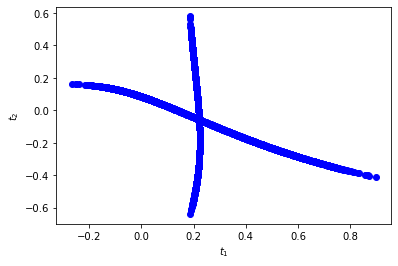

In [53]:
plt.scatter(encoded_points[mask_cluster1,0],encoded_points[mask_cluster1,1],color='blue')
plt.scatter(encoded_points[mask_cluster2,0],encoded_points[mask_cluster2,1],color='red')
plt.xlabel('$t_1$')
plt.ylabel('$t_2$')
plt.show()

In [64]:
# KMeans clustering
from sklearn.cluster import KMeans

model = KMeans(n_clusters=2)
# fit model and predict clusters
yhat = model.fit_predict(encoded_points)

mask_cluster1 = yhat==0
mask_cluster2 = yhat==1

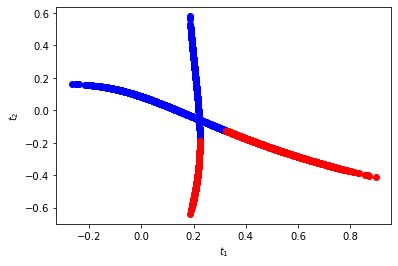

In [65]:
plt.scatter(encoded_points[mask_cluster1,0],encoded_points[mask_cluster1,1],color='blue')
plt.scatter(encoded_points[mask_cluster2,0],encoded_points[mask_cluster2,1],color='red')
plt.xlabel('$t_1$')
plt.ylabel('$t_2$')
plt.show()

In [83]:
# MiniBatchKMeans clustering
from sklearn.cluster import MiniBatchKMeans

model = MiniBatchKMeans(n_clusters=2)
# fit model and predict clusters
yhat = model.fit_predict(encoded_points)

mask_cluster1 = yhat==0
mask_cluster2 = yhat==1
# mask_cluster3 = yhat==2
# mask_cluster4 = yhat==3

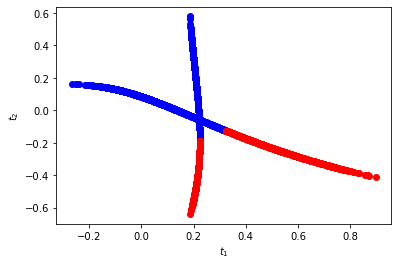

In [84]:
plt.scatter(encoded_points[mask_cluster1,0],encoded_points[mask_cluster1,1],color='blue')
plt.scatter(encoded_points[mask_cluster2,0],encoded_points[mask_cluster2,1],color='red')
# plt.scatter(encoded_points[mask_cluster3,0],encoded_points[mask_cluster3,1],color='green')
# plt.scatter(encoded_points[mask_cluster4,0],encoded_points[mask_cluster4,1],color='yellow')
plt.xlabel('$t_1$')
plt.ylabel('$t_2$')
plt.show()

In [102]:
# SpectralClustering clustering
from sklearn.cluster import SpectralClustering

model = SpectralClustering(n_clusters=2)
# fit model and predict clusters
yhat = model.fit_predict(encoded_points)

mask_cluster1 = yhat==0
mask_cluster2 = yhat==1
# mask_cluster3 = yhat==2
# mask_cluster4 = yhat==3

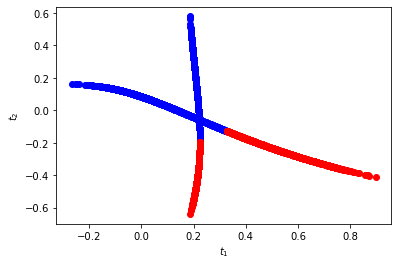

In [103]:
plt.scatter(encoded_points[mask_cluster1,0],encoded_points[mask_cluster1,1],color='blue')
plt.scatter(encoded_points[mask_cluster2,0],encoded_points[mask_cluster2,1],color='red')
# plt.scatter(encoded_points[mask_cluster3,0],encoded_points[mask_cluster3,1],color='green')
# plt.scatter(encoded_points[mask_cluster4,0],encoded_points[mask_cluster4,1],color='yellow')
plt.xlabel('$t_1$')
plt.ylabel('$t_2$')
plt.show()

In [98]:
# GaussianMixture clustering
from sklearn.mixture import GaussianMixture

model = GaussianMixture(n_components=2)
# fit model and predict clusters
yhat = model.fit_predict(encoded_points)

mask_cluster1 = yhat==0
mask_cluster2 = yhat==1
# mask_cluster3 = yhat==2
# mask_cluster4 = yhat==3

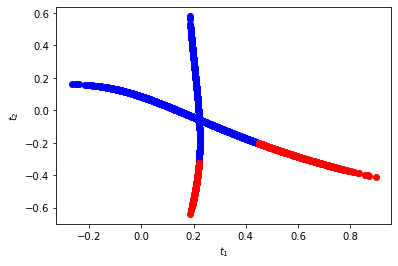

In [99]:
plt.scatter(encoded_points[mask_cluster1,0],encoded_points[mask_cluster1,1],color='blue')
plt.scatter(encoded_points[mask_cluster2,0],encoded_points[mask_cluster2,1],color='red')
# plt.scatter(encoded_points[mask_cluster3,0],encoded_points[mask_cluster3,1],color='green')
# plt.scatter(encoded_points[mask_cluster4,0],encoded_points[mask_cluster4,1],color='yellow')
plt.xlabel('$t_1$')
plt.ylabel('$t_2$')
plt.show()

# ICI

In [104]:
# BIRCH clustering
from sklearn.cluster import Birch

model = Birch(threshold=0.01, n_clusters=2)
# fit model and predict clusters
yhat = model.fit_predict(encoded_points)

mask_cluster1 = yhat==0
mask_cluster2 = yhat==1
# mask_cluster3 = yhat==2
# mask_cluster4 = yhat==3

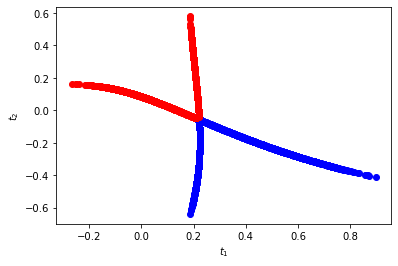

In [105]:
plt.scatter(encoded_points[mask_cluster1,0],encoded_points[mask_cluster1,1],color='blue')
plt.scatter(encoded_points[mask_cluster2,0],encoded_points[mask_cluster2,1],color='red')
# plt.scatter(encoded_points[mask_cluster3,0],encoded_points[mask_cluster3,1],color='green')
# plt.scatter(encoded_points[mask_cluster4,0],encoded_points[mask_cluster4,1],color='yellow')
plt.xlabel('$t_1$')
plt.ylabel('$t_2$')
plt.show()

<Figure size 432x288 with 0 Axes>

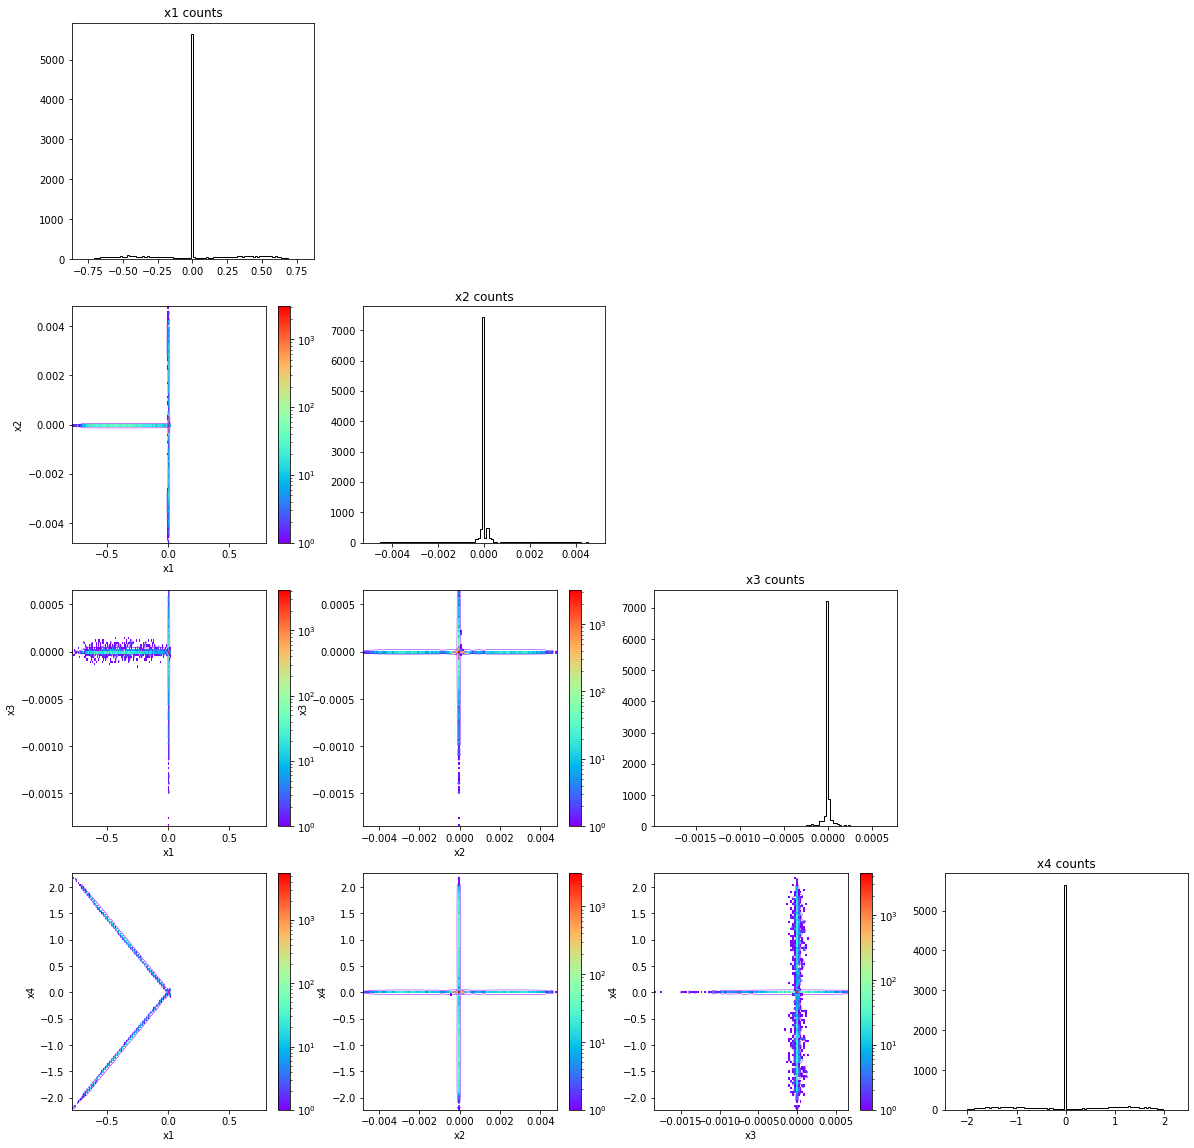

In [106]:
plt.figure(1)
triangular_plot_axes_lim(x,mask_cluster1)

<Figure size 432x288 with 0 Axes>

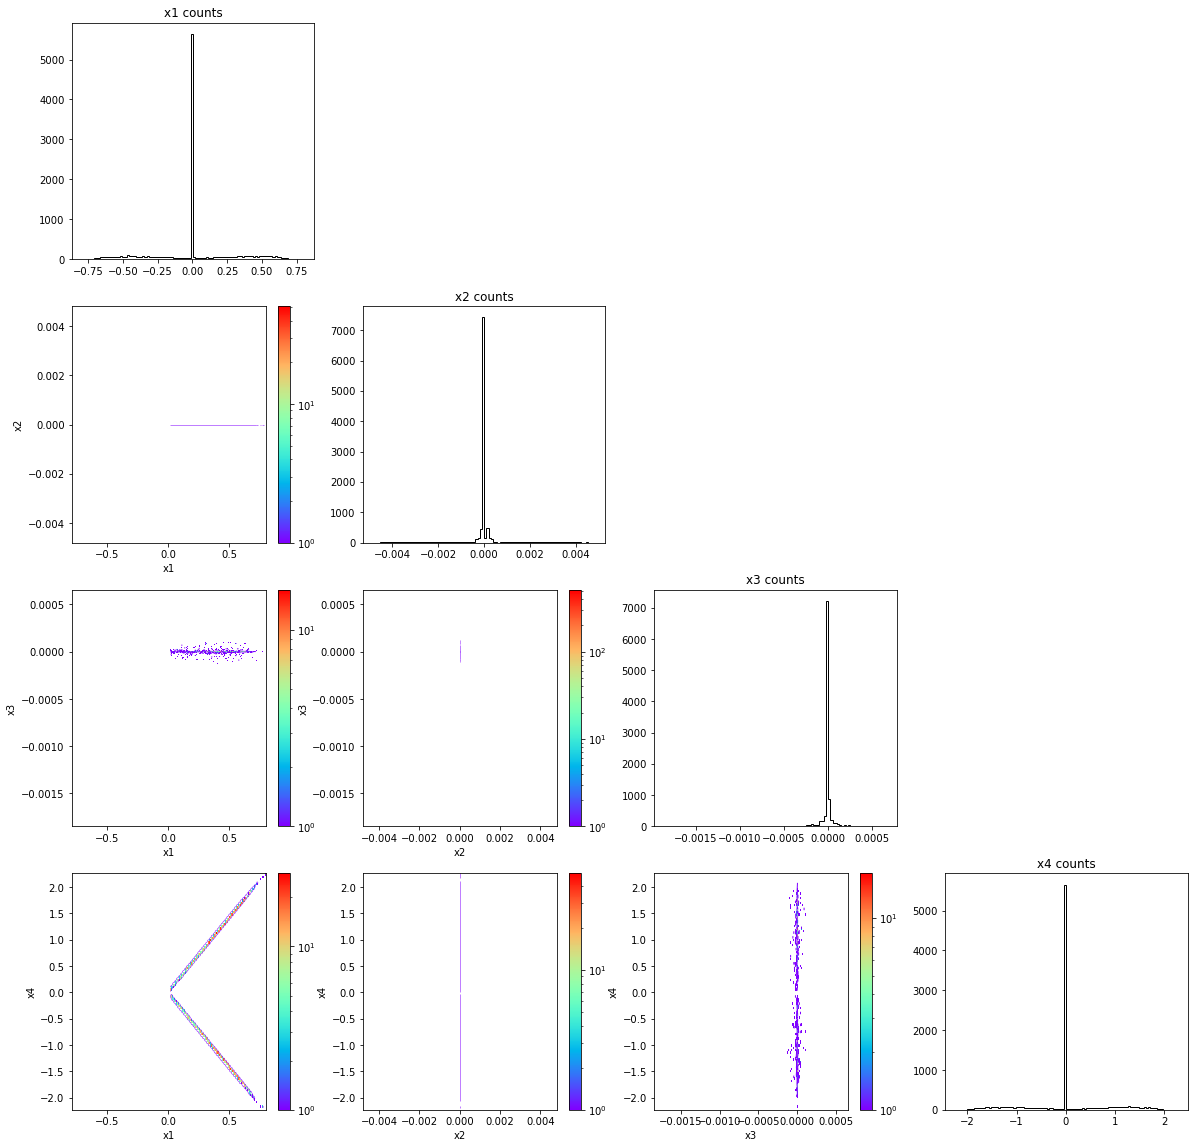

In [107]:
plt.figure(1)
triangular_plot_axes_lim(x,mask_cluster2)